In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

import optuna
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


import warnings
warnings.simplefilter('ignore')


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


RANDOM_SEED = 28

In [2]:
# Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

Посмотрим на данные

In [3]:
train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [4]:
test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [5]:
sample.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


Объединим train и test в один датафрейм для удобства обработки.

In [6]:
test['default'] = -1
test['sample'] = 0
train['sample'] = 1
df = pd.concat([train, test], ignore_index=True)

In [7]:
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
df.describe(include='all')

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
count,110148.000000,110148,109670,110148,110148.000000,110148,110148,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148,110148.000000,110148.000000
unique,NaN,120,5,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,18MAR2014,SCH,F,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN
freq,NaN,1491,57998,61836,NaN,74290,89140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93721,NaN,NaN
mean,55074.500000,NaN,NaN,NaN,39.249410,NaN,NaN,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,NaN,-0.244916,0.669999
std,31797.133063,NaN,NaN,NaN,11.518063,NaN,NaN,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,NaN,0.595908,0.470215
min,1.000000,NaN,NaN,NaN,21.000000,NaN,NaN,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,NaN,-1.000000,0.000000
25%,27537.750000,NaN,NaN,NaN,30.000000,NaN,NaN,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,NaN,-1.000000,0.000000
50%,55074.500000,NaN,NaN,NaN,37.000000,NaN,NaN,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,NaN,0.000000,1.000000
75%,82611.250000,NaN,NaN,NaN,48.000000,NaN,NaN,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,NaN,0.000000,1.000000


In [10]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

В данных 19 столбцов (без Sample) и 110148 строк. Пропущенные значения в небольшом количестве, и только у одного признака - education.

## Предобработка данных
Посмотрим какие признаки у нас есть:

In [11]:
df.agg({'nunique', lambda s: s.unique()[:5]}).T

,nunique,<lambda>
client_id,110148,"[25905, 63161, 25887, 16222, 101655]"
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1..."
education,5,"[SCH, GRD, UGR, PGR, ACD]"
sex,2,"[M, F]"
age,52,"[62, 59, 25, 53, 48]"
car,2,"[Y, N]"
car_type,2,"[Y, N]"
decline_app_cnt,24,"[0, 2, 1, 3, 4]"
good_work,2,"[0, 1]"
score_bki,102618,"[-2.00875292, -1.53227621, -1.40814226, -2.057..."


Разобьем их по типам:

In [12]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport',
            'good_work', ]  # Бинарные признаки
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time']  # Категориальные признаки
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
            'score_bki', 'region_rating']  # Числовые признаки

# Функции 

In [13]:
def print_emission_boundaries(num_column):
    '''Печатает границы выбросов'''    
    q25 = round(num_column.quantile(0.25), 2)
    q75 = round(num_column.quantile(0.75), 2)
    iqr = q75 - q25
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    print(
        f'25й квантиль: {q25}, 75й квантиль: {q75}, IQR: {iqr}, Границы выбросов: [{lower_bound}, {upper_bound}]')


def print_describe_and_graphs_num(df, column_name, target_name):
    '''Печатает характеристики и графики для числовых столбцов'''
    display(df[column_name].describe())
    sns.distplot(df[column_name], kde=False, rug=False)
    plt.show()
    sns.boxplot(x=target_name, y=column_name, data=df)

        

def print_describe_and_graphs_cat(df, column_name, target_name):
    '''Печатает характеристики и графики для категориальных и бинарных признаков'''
    display(df[column_name].describe())
    print()
    display(df[column_name].value_counts())
    sns.countplot(x=column_name, data=df)
    plt.figure(figsize=(15, 6))
    sns.countplot(y=column_name, hue=target_name, data=df, palette="husl")   
    for i in df[column_name].unique():
        def_proc = (len(df[(df[column_name] == i) & (df[target_name] == 1)])) / \
            (len(df[(df[column_name] == i) & (df[target_name] != -1)]))
        print(
            f'Процент дефолтных клиентов с параметром {column_name} = {i}: {round(def_proc*100, 2)}%')
    
        

In [14]:
def create_pca(df, features):
    '''Создание нового столбца рса'''
    x = df.loc[:, features]
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    pca = PCA(n_components=1)
    return pca.fit_transform(x)

In [15]:
def classification(model, X_train, y_train, X_valid):
    '''Обучение модели и предсказывание результата'''
    model = model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)
    probs = probs[:, 1]
    y_pred = model.predict(X_valid)
    model_name = str(type(model))
    model_name = model_name[model_name.rfind('.')+1:-2]
    return y_pred, probs, model_name


def print_metrics(y_valid, y_pred, probs, model_name):
    '''Печать метрик для модели'''
    fpr, tpr, threshold = roc_curve(y_valid, probs)
    roc_auc = roc_auc_score(y_valid, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title(f'{model_name} ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    print('accuracy_score:', accuracy_score(y_valid, y_pred))
    print('precision_score:', precision_score(y_valid, y_pred))
    print('recall_score:', recall_score(y_valid, y_pred))
    print('f1_score:', f1_score(y_valid, y_pred))

    cm = confusion_matrix(y_valid, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')


def get_metrics_for_df(y_valid, y_pred, probs, name):
    '''Получение метрик для записи в датафрейм со всеми результатами метрик '''
    roc_auc = roc_auc_score(y_valid, probs)
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    score = {'model': name,
             'roc_auc': roc_auc,
             'accuracy': accuracy,
             'precision': precision,
             'recall': recall,
             'f1_score': f1,
             'confusion_matrix': cm
             }

    return score


def classification_and_metrics(model, X_train, y_train, X_valid, name=''):
    '''Обучает модель, печатает метрики для неё и возвращает все метрики для записи в датафрейм'''
    y_pred, probs, model_name = classification(model, X_train, y_train, X_valid)
    print_metrics(y_valid, y_pred, probs, model_name)
    return get_metrics_for_df(y_valid, y_pred, probs, model_name + name)

# EDA

Для начала рассмотрим целевую переменную - default.

 0    64427
-1    36349
 1     9372
Name: default, dtype: int64

<AxesSubplot:xlabel='count', ylabel='default'>

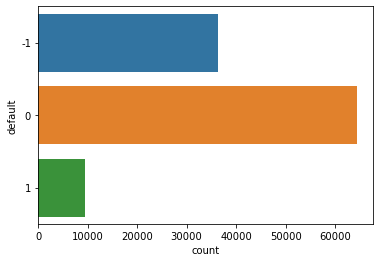

In [16]:
display(df['default'].value_counts())
sns.countplot(y='default', data=df)

По графику видно, что клиентов с дефолтом почти в 7 раз меньше, возможно придется исскуственно добавить данные о клиентах с дефолтом или убрать данные о клиентах без дефолта. Построим графики по всем числовым переменным

<Figure size 1200x800 with 0 Axes>

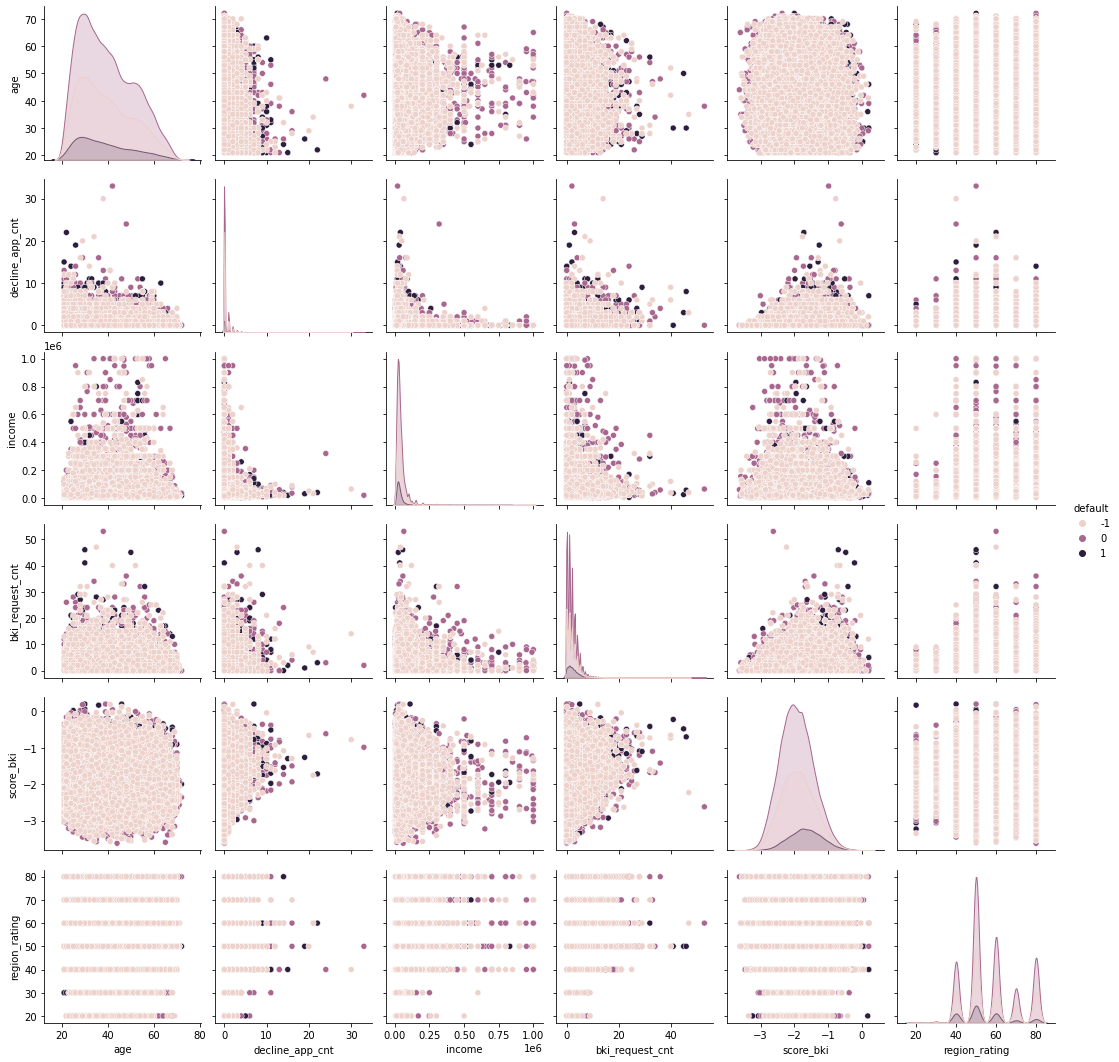

In [17]:
df1 = df[num_cols]
df1['default'] = df['default']
plt.figure(figsize=(15, 10), dpi=80)
sns.pairplot(df1, kind='scatter', hue='default')
plt.show()

## Education

Перед тем как начать анализ этого признака заменим пропущенные значения самым популярным значением

In [18]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [19]:
df.education.fillna('SCH', inplace=True)

count     110148
unique         5
top          SCH
freq       58476
Name: education, dtype: object

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Процент дефолтных клиентов с параметром education = SCH: 15.03%
Процент дефолтных клиентов с параметром education = GRD: 9.01%
Процент дефолтных клиентов с параметром education = UGR: 13.15%
Процент дефолтных клиентов с параметром education = PGR: 6.44%
Процент дефолтных клиентов с параметром education = ACD: 4.12%


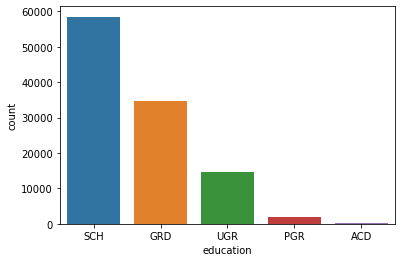

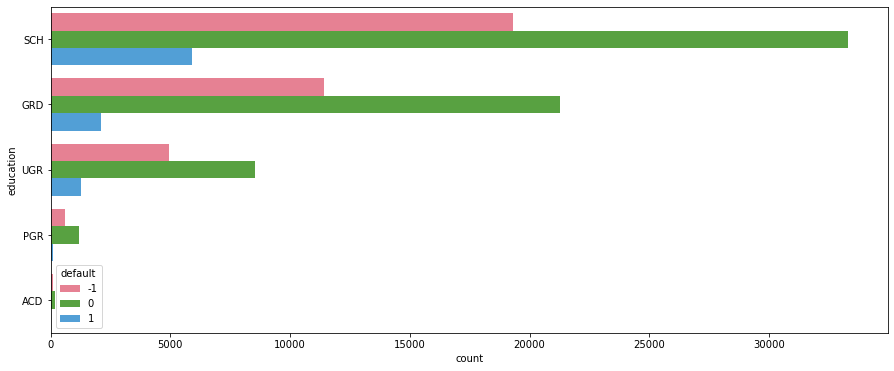

In [20]:
print_describe_and_graphs_cat(df, 'education', 'default')

Для начала разберемся с сокращениями:
- SCH - среднее образование
- UGR - бакалавриат
- GRD - магистратура
- PGR - ученая степень
- ACD - высшая категория

Таким образом мы видим что люди с образованием выше ученой степени намного реже берут кредиты. Так же мы видим что чем выше образование тем ниже шанс дефолта. Возможно это потому что у них выше доход? Давайте проверим.

<AxesSubplot:xlabel='education', ylabel='income'>

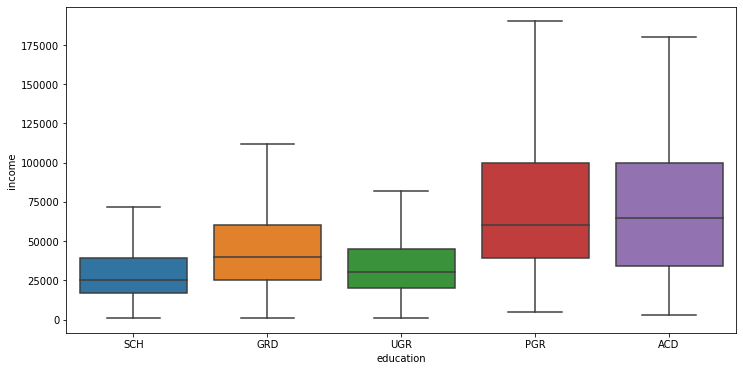

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="education", y="income", data=df, showfliers=False)

Как и предполагалось, мы видим что чем выше уровень образования, тем в среднем выше доход

## Sex

count     110148
unique         2
top            F
freq       61836
Name: sex, dtype: object

F    61836
M    48312
Name: sex, dtype: int64

Процент дефолтных клиентов с параметром sex = M: 13.44%
Процент дефолтных клиентов с параметром sex = F: 12.12%


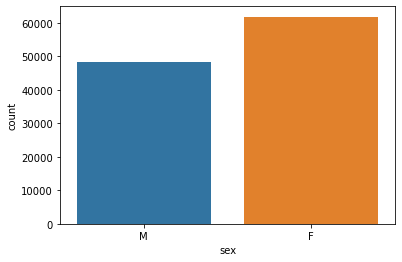

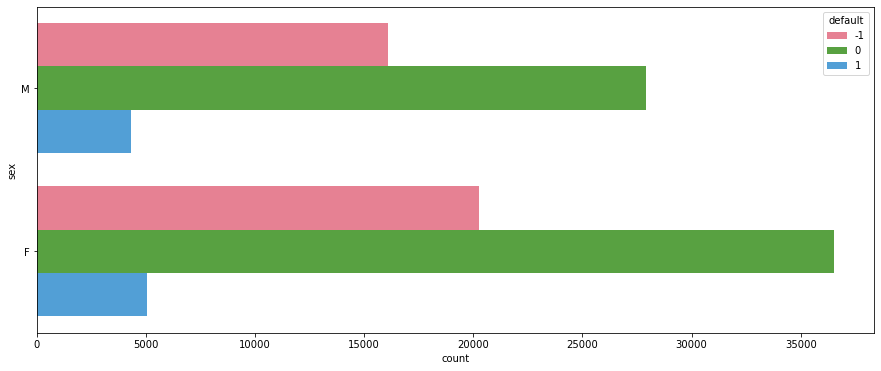

In [22]:
print_describe_and_graphs_cat(df, 'sex', 'default')

Женщин представлено немного больше чем мужчин. Так же заметно, что мужчины немного чаще терпят дефолт

## Age

25й квантиль: 30.0, 75й квантиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]


count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

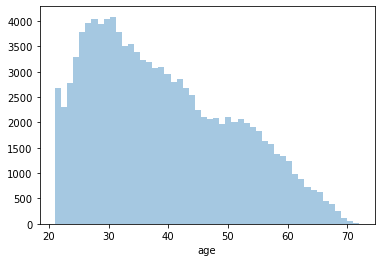

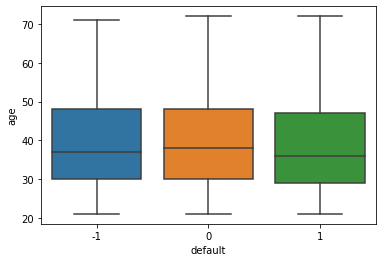

In [23]:
print_emission_boundaries(df['age'])
print_describe_and_graphs_num(df, 'age', 'default')

Выбросов нет, распределение смещено влево. Давайте посмотрим как изменится распределение если мы логарифмируем переменную

In [24]:
df.age = df.age.apply(lambda x: np.log(x))

25й квантиль: 3.4, 75й квантиль: 3.87, IQR: 0.4700000000000002, Границы выбросов: [2.6949999999999994, 4.575]


count    110148.000000
mean          3.627212
std           0.292797
min           3.044522
25%           3.401197
50%           3.610918
75%           3.871201
max           4.276666
Name: age, dtype: float64

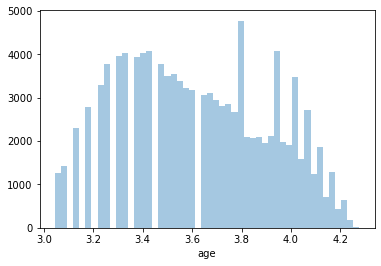

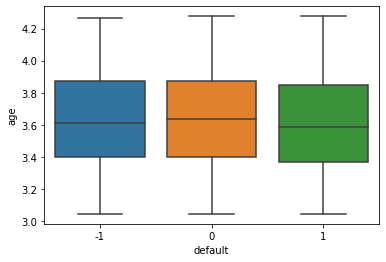

In [25]:
print_emission_boundaries(df['age'])
print_describe_and_graphs_num(df, 'age', 'default')

Распределение стало немного лучше. Оставим так.

## Car

count     110148
unique         2
top            N
freq       74290
Name: car, dtype: object

N    74290
Y    35858
Name: car, dtype: int64

Процент дефолтных клиентов с параметром car = Y: 10.63%
Процент дефолтных клиентов с параметром car = N: 13.7%


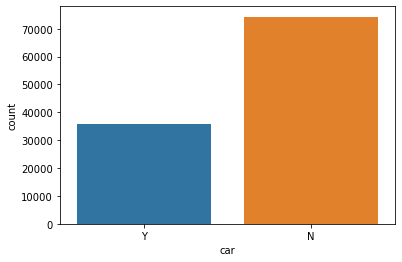

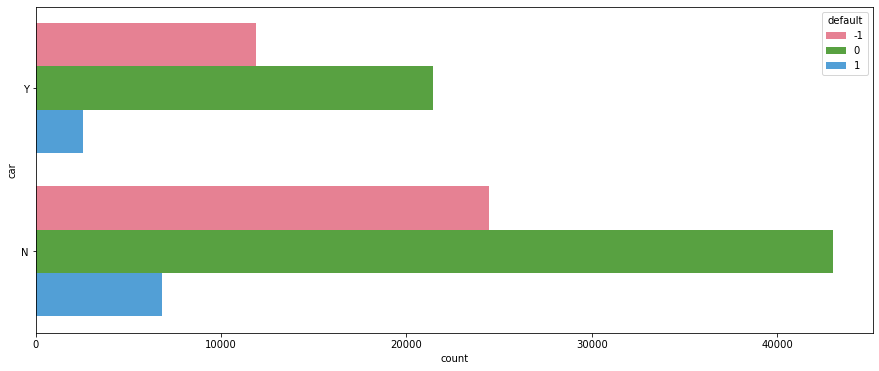

In [26]:
print_describe_and_graphs_cat(df, 'car', 'default')

У большинства клиентов нет машины. Так же клиенты без машины чаще терпят дефолт.

## Car type

count     110148
unique         2
top            N
freq       89140
Name: car_type, dtype: object

N    89140
Y    21008
Name: car_type, dtype: int64

Процент дефолтных клиентов с параметром car_type = Y: 8.75%
Процент дефолтных клиентов с параметром car_type = N: 13.63%


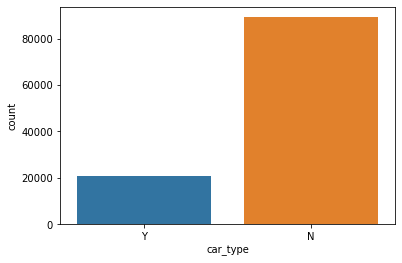

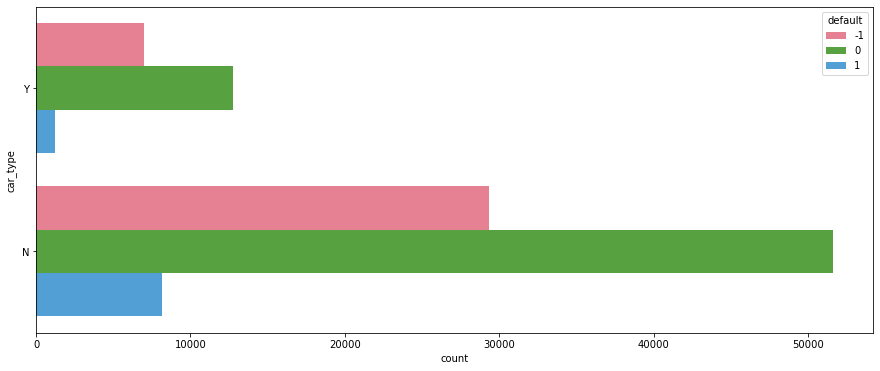

In [27]:
print_describe_and_graphs_cat(df, 'car_type', 'default')

Так как большинство клиентов не имеют машину, следовательно еще большее количество клиентов не имеет иномарку. Процент дефолтных клиентов не имеющих иномарку выше. Возможно придется объединить 2 признака с машинами в один.

## Decline app cnt

25й квантиль: 0.0, 75й квантиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]


count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

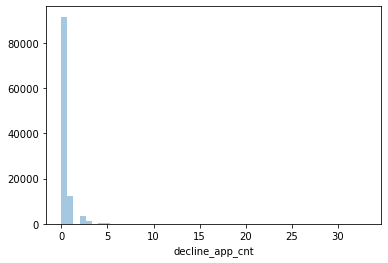

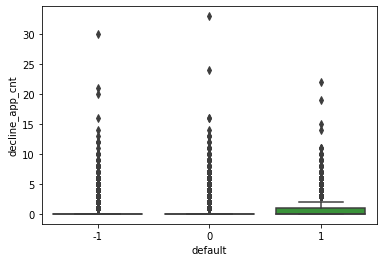

In [28]:
print_emission_boundaries(df['decline_app_cnt'])
print_describe_and_graphs_num(df, 'decline_app_cnt', 'default')

Большинству клиентов не отказывали, поэтому графики ведут себя так странно. Посмотрим поближе на редкие случаи.

<AxesSubplot:xlabel='decline_app_cnt'>

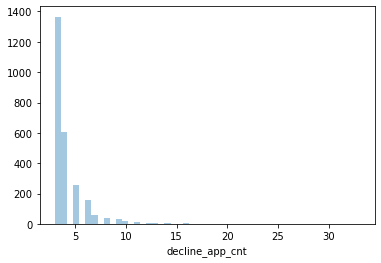

In [29]:
sns.distplot(df[df['decline_app_cnt'] > 2]['decline_app_cnt'], kde=False, rug=False)

Заменим все значения больше 3 на 4.

In [30]:
df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: 3 if x > 3 else x)

count    110148.000000
mean          0.248838
std           0.625990
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: decline_app_cnt, dtype: float64

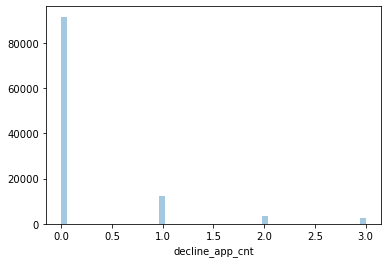

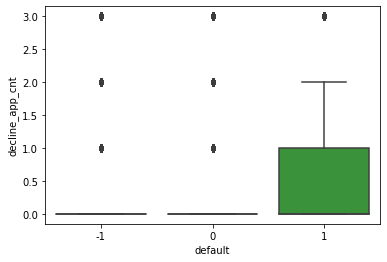

In [31]:
print_describe_and_graphs_num(df, 'decline_app_cnt', 'default')

## Good work 

count    110148.000000
mean          0.165514
std           0.371645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: good_work, dtype: float64

0    91917
1    18231
Name: good_work, dtype: int64

Процент дефолтных клиентов с параметром good_work = 0: 13.34%
Процент дефолтных клиентов с параметром good_work = 1: 9.45%


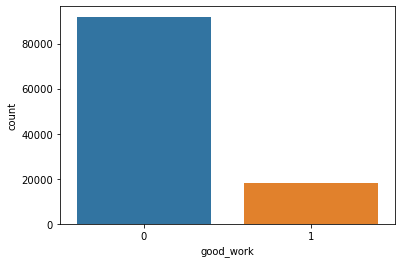

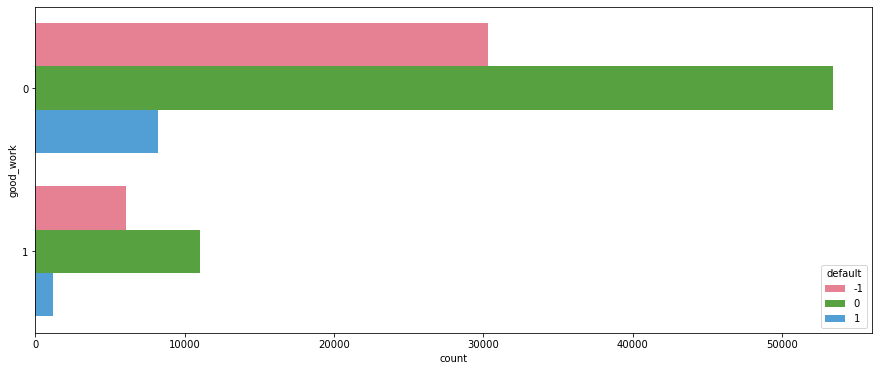

In [32]:
print_describe_and_graphs_cat(df, 'good_work', 'default')

Обладателей хорошей работы почти в 5 раз меньше. Так же среди обладателей хорошей работы немного ниже процент дефолтных клиентов. Давайте посмотрим хорошая работа = высокий доход или не совсем.

<AxesSubplot:xlabel='good_work', ylabel='income'>

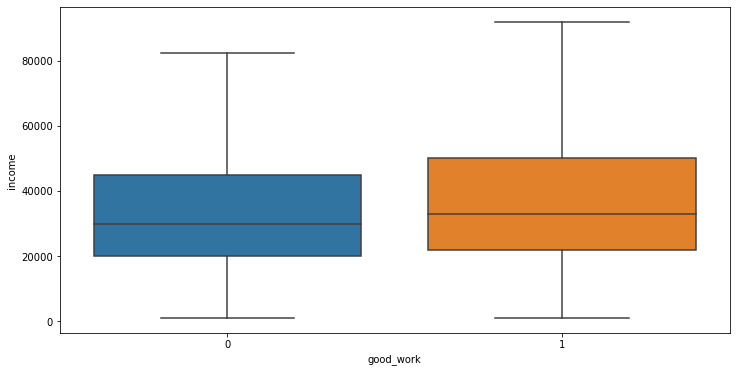

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="good_work", y="income", data=df, showfliers=False)

Доход немного выше, но не сильно.

## bki_request_cnt

25й квантиль: 0.0, 75й квантиль: 3.0, IQR: 3.0, Границы выбросов: [-4.5, 7.5]


count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

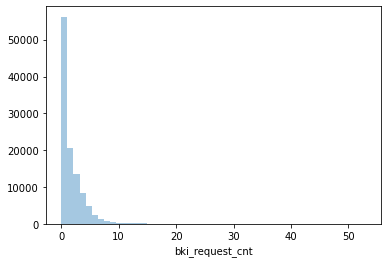

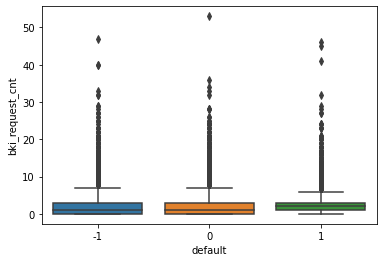

In [34]:
print_emission_boundaries(df['bki_request_cnt'])
print_describe_and_graphs_num(df, 'bki_request_cnt', 'default')

Есть выбросы. Давайте посмотрим на них повнимательнее.

<AxesSubplot:xlabel='bki_request_cnt'>

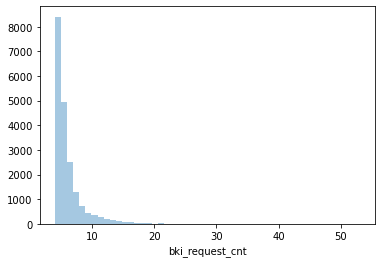

In [35]:
sns.distplot(df[df['bki_request_cnt'] > 3]['bki_request_cnt'], kde=False, rug=False)

Чтобы избавиться от выбросов, заменим все значения больше 3 на 4.

count    110148.000000
mean          1.710816
std           1.434191
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           4.000000
Name: bki_request_cnt, dtype: float64

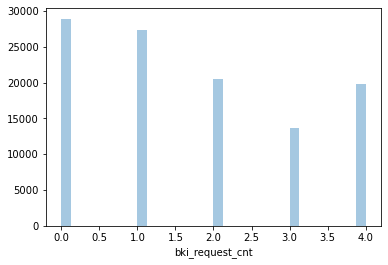

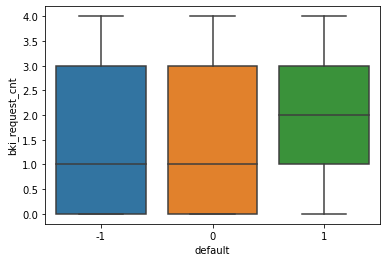

In [36]:
df['bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x: 4 if x > 3 else x)
print_describe_and_graphs_num(df, 'bki_request_cnt', 'default')

График явно стал лучше. Так же по графику видно, что у дефолтных клиентов в среднем больше запросов в БКИ.

## home_address

count    110148.000000
mean          1.574945
std           0.527562
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: home_address, dtype: float64

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

Процент дефолтных клиентов с параметром home_address = 1: 9.29%
Процент дефолтных клиентов с параметром home_address = 2: 15.51%
Процент дефолтных клиентов с параметром home_address = 3: 11.61%


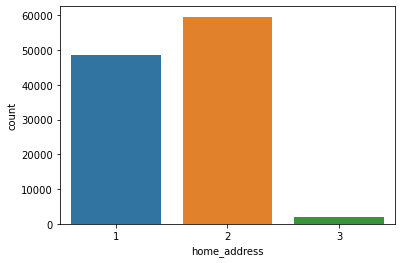

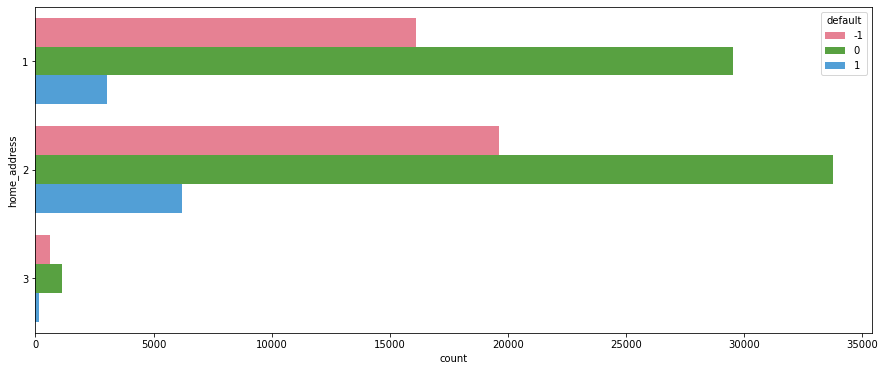

In [37]:
print_describe_and_graphs_cat(df, 'home_address', 'default')

Жителей 1 и 2 адреса намного больше, чем 3.

## work_address 

count    110148.000000
mean          2.497867
std           0.687651
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: work_address, dtype: float64

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

Процент дефолтных клиентов с параметром work_address = 2: 10.25%
Процент дефолтных клиентов с параметром work_address = 3: 14.8%
Процент дефолтных клиентов с параметром work_address = 1: 7.42%


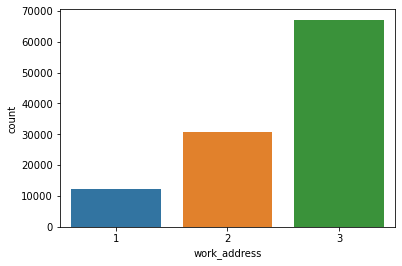

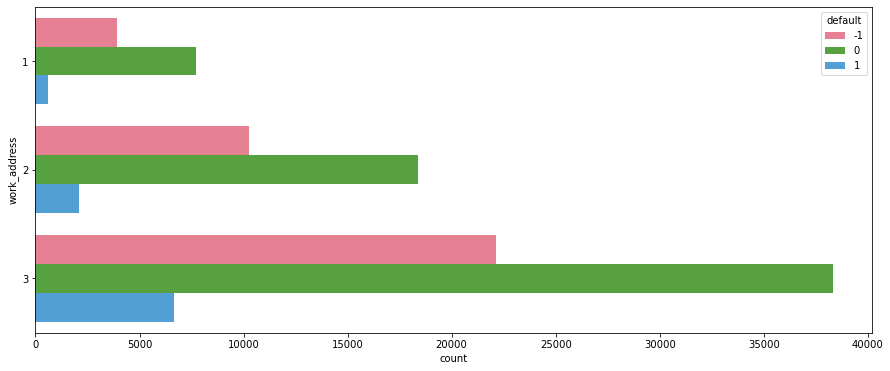

In [38]:
print_describe_and_graphs_cat(df, 'work_address', 'default')

Рабочие адреса созредоточены на 3, их больше чем 1 и 2 вместе взятых. Так же именно 3 чаще всего терпят дефолт.

## income 

25й квантиль: 20000.0, 75й квантиль: 48000.0, IQR: 28000.0, Границы выбросов: [-22000.0, 90000.0]


count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

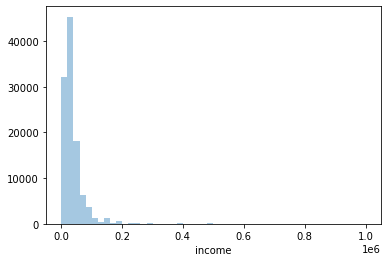

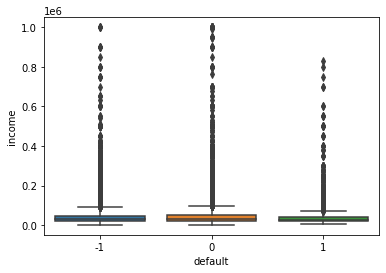

In [39]:
print_emission_boundaries(df['income'])
print_describe_and_graphs_num(df, 'income', 'default')

Суммы дохода достигают очень больших цифр. Попробуем логорифмировать.

In [40]:
df.income = df.income.apply(lambda x: np.log(x))

25й квантиль: 9.9, 75й квантиль: 10.78, IQR: 0.879999999999999, Границы выбросов: [8.580000000000002, 12.099999999999998]


count    110148.000000
mean         10.345751
std           0.696662
min           6.907755
25%           9.903488
50%          10.308953
75%          10.778956
max          13.815511
Name: income, dtype: float64

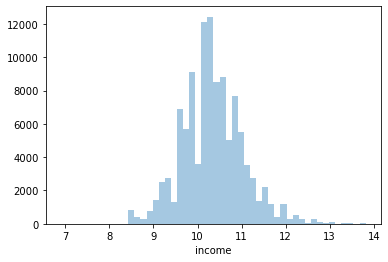

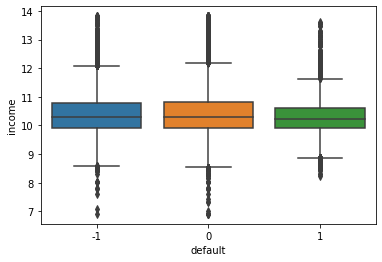

In [41]:
print_emission_boundaries(df['income'])
print_describe_and_graphs_num(df, 'income', 'default')

Распределение явно стало лучше и даже похоже на нормальное.

## Foreign_passport

count     110148
unique         2
top            N
freq       93721
Name: foreign_passport, dtype: object

N    93721
Y    16427
Name: foreign_passport, dtype: int64

Процент дефолтных клиентов с параметром foreign_passport = N: 13.63%
Процент дефолтных клиентов с параметром foreign_passport = Y: 7.41%


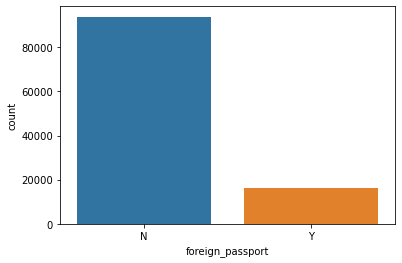

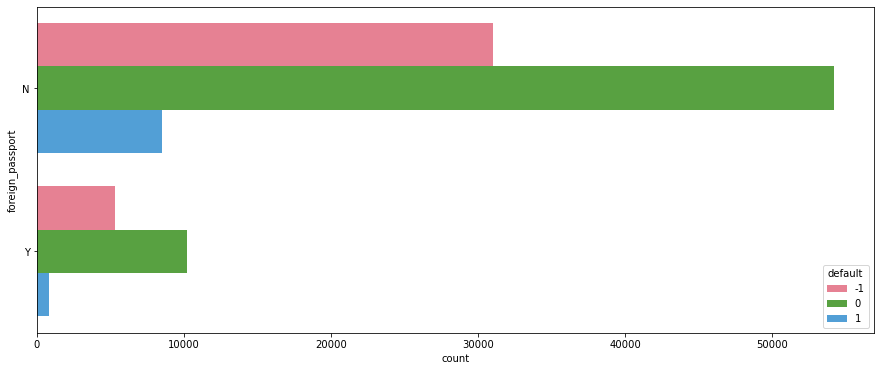

In [42]:
print_describe_and_graphs_cat(df, 'foreign_passport', 'default')

Намного больше клиентов не имеют загранпаспорта. Клиенты у которых нет загранпаспортов чаще дефолтятся.

## sna

count    110148.000000
mean          1.731588
std           1.122652
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

Процент дефолтных клиентов с параметром sna = 4: 21.15%
Процент дефолтных клиентов с параметром sna = 1: 9.82%
Процент дефолтных клиентов с параметром sna = 2: 14.98%
Процент дефолтных клиентов с параметром sna = 3: 15.77%


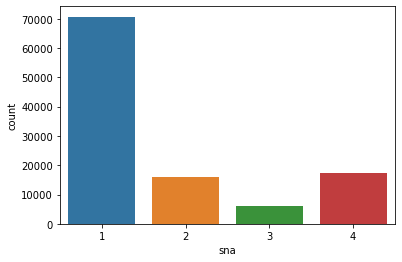

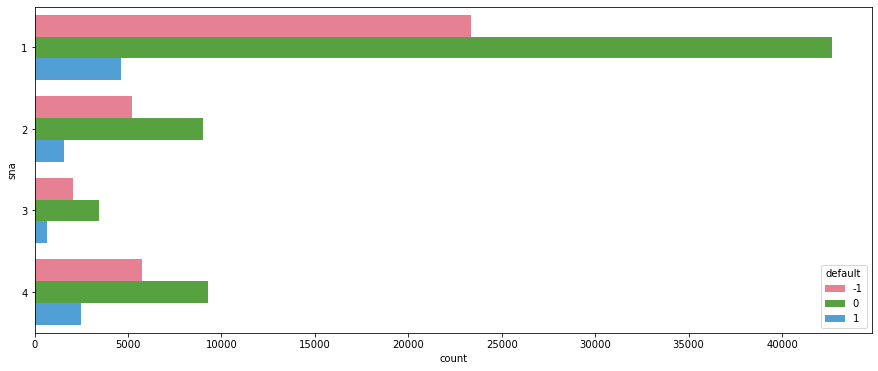

In [43]:
print_describe_and_graphs_cat(df, 'sna', 'default')

## first_time

count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

Процент дефолтных клиентов с параметром first_time = 1: 18.61%
Процент дефолтных клиентов с параметром first_time = 4: 8.2%
Процент дефолтных клиентов с параметром first_time = 3: 12.03%
Процент дефолтных клиентов с параметром first_time = 2: 15.54%


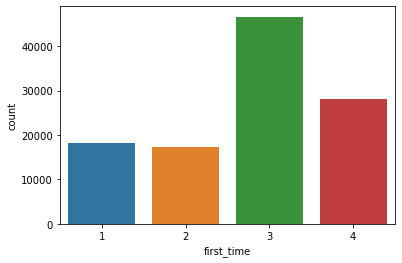

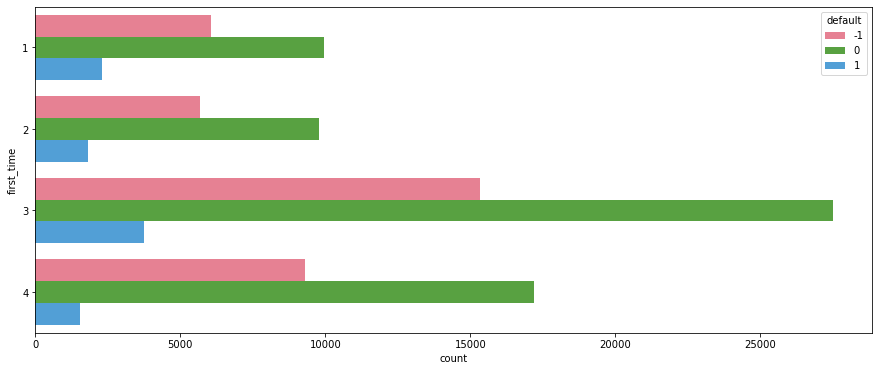

In [44]:
print_describe_and_graphs_cat(df, 'first_time', 'default')

Чем дольше банк знаком с клиентом,  тем меньше процент дефолтных клиентов

## score_bki 

25й квантиль: -2.26, 75й квантиль: -1.57, IQR: 0.6899999999999997, Границы выбросов: [-3.2949999999999995, -0.5350000000000004]


count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

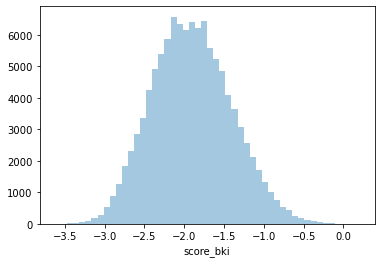

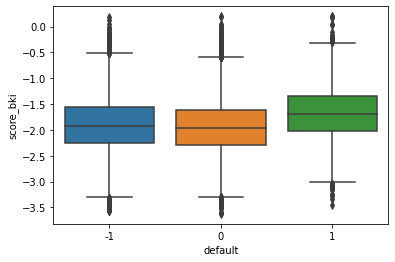

In [45]:
print_emission_boundaries(df['score_bki'])
print_describe_and_graphs_num(df, 'score_bki', 'default')

Распределение выглядит практически нормально, есть немного выбросов, но думаю их лучше оставить как есть

## region_rating 

Мне кажется, тут правильней будет проводить анализ для категориальных пременных, несмотря на то, что я этот признак отнесла к числовым.

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

Процент дефолтных клиентов с параметром region_rating = 50: 13.61%
Процент дефолтных клиентов с параметром region_rating = 80: 7.32%
Процент дефолтных клиентов с параметром region_rating = 60: 12.88%
Процент дефолтных клиентов с параметром region_rating = 40: 16.97%
Процент дефолтных клиентов с параметром region_rating = 70: 9.24%
Процент дефолтных клиентов с параметром region_rating = 20: 21.36%
Процент дефолтных клиентов с параметром region_rating = 30: 19.0%


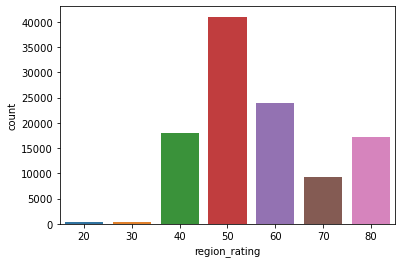

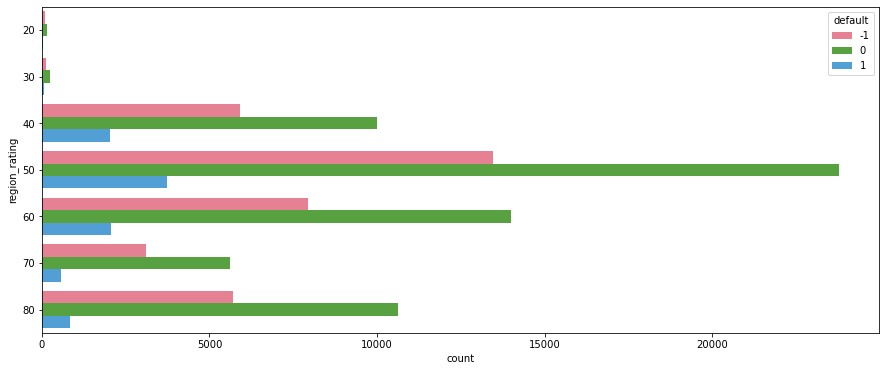

In [46]:
print_describe_and_graphs_cat(df, 'region_rating', 'default')

Очень мало представителей с низким рейтингом региона (20 и 30), и вот они то чаще всех терпят дефолт.

<AxesSubplot:>

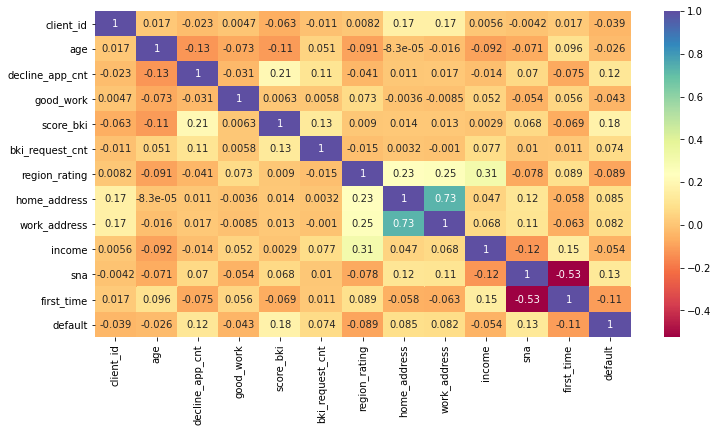

In [47]:
df_train = df[df['sample'] == 1].drop(['sample'], axis=1)
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), cmap='Spectral', annot=True)

Видим сильную корреляцию между рабочим и домашним адресом, в последствии решим этот вопрос. Так же есть менее сильная корреляция между признаками first_time и sna - эти признаки трогать не будем.

# Построение базовой модели

In [48]:
train = df[df['sample'] == 1]
test = df[df['sample'] == 0]
columns_for_drop = ['client_id', 'app_date', 'education', 'sex',
                    'car', 'car_type', 'foreign_passport', 'sample', 'default']
X = train.drop(columns_for_drop, axis=1)
y = train['default']
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=RANDOM_SEED)

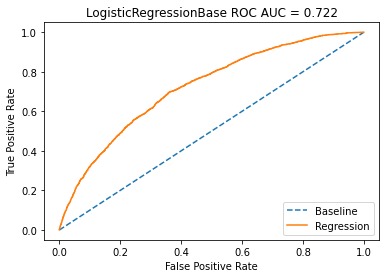

accuracy_score: 0.8720325203252033
precision_score: 0.47619047619047616
recall_score: 0.021222410865874362
f1_score: 0.04063388866314507


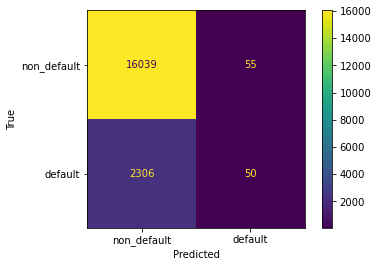

In [49]:
model = LogisticRegression()
y_pred, probs, model_name = classification(model, X_train, y_train, X_valid)
print_metrics(y_valid, y_pred, probs, model_name + 'Base')
# Создадим датафрейм в котором будет информация о показаниях метрик для каждой из моделей
report = pd.DataFrame(
    columns=['model', 'roc_auc', 'accuracy', 'precision', 'recall', 'f1_score'])
report = report.append(get_metrics_for_df(
    y_valid, y_pred, probs, model_name+'Base'), ignore_index=True)

In [50]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.47619,0.021222,0.040634,"[[16039, 55], [2306, 50]]"


Модель показала неплохой результат по roc auc и accuracy, но если посмотреть на остальные метрики, станет понятно, что модель работает плохо. Практически каждому она выдает кредит. Скорее всего проблема в несбалансированности классов.

# Feature engeneereeng

Для начала приведем столбец с датой к читаемому виду

In [51]:
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

Теперь посмотрим уникальные значения годов, месяцев и дней

In [52]:
print(f'Уникальные года: {df.app_date.apply(lambda x: x.year).unique()}')
print(f'Уникальные месяца: {df.app_date.apply(lambda x: x.month).unique()}')
print(f'Уникальные дни: {df.app_date.apply(lambda x: x.day).unique()}')

Уникальные года: [2014]
Уникальные месяца: [2 3 1 4]
Уникальные дни: [ 1 12 23 18  4 17 14 10  3  8 19 22 30 11  2  6 24 15 28  9 31 26 13 25
 21 20 16 27  7  5 29]


Столбец с годами создавать не имеет смысла, так как все данные в датасете за 2014 год. Столбцы с месяцами и днями мы создадим. Так же создадим столбец в котором будет указано количество дней с начала отчетности. Сначала была идея создать столбец с бинарным признаком выходной день или нет, но этот признак не принес пользу модели.

In [53]:
df['month'] = df.app_date.apply(lambda x: x.month)
# df['day'] = df.app_date.apply(lambda x: x.day)
df['days'] = df['app_date']-min(df['app_date'])
df['days'] = df['days'].apply(lambda x: x.days)

Добавим названия новых численных признаков в список, и удалим столбец app_date - он больше не пригодится

In [54]:
num_cols.extend(['month', 'days'])
df.drop(['app_date'], inplace=True, axis=1)

Путем ручного подбора я оставила 3 признака полученных с помощью группировки

In [55]:
# среднее количество запросов в БКИ по возрасту
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [56]:
# средний доход по рейтингу региона
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

In [57]:
# среднее количество запросов в БКИ по доходу
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

In [58]:
# Добавляем новые численные признаки в список
num_cols.extend(['mean_requests_age', 'mean_income_region', 'mean_requests_income'])

В таблице корреляций была выявлена сильная корреляция между двумя признаками адресов. Объединим их в один признак методом PCA.

In [59]:
features = ['home_address', 'work_address']
df['pca_address'] = create_pca(df,features)
df.drop(features, inplace=True, axis=1)
# Удалим эти признаки из списка категориальных
for i in features:
    cat_cols.remove(i)
# И добавим в числовой список
num_cols.append('pca_address')

Теперь закодируем бинарные и категориальные признаки 

In [60]:
le = LabelEncoder()
for i in bin_cols:
    df[i] = le.fit_transform(df[i])

# Создадим пустой список, в который будем записывать новые категориальные признаки
new_cat_cols = []
ohe = OneHotEncoder(sparse=False)
for i in cat_cols:
    cat_array = ohe.fit_transform(df[[i]])
    column_name = [i+'_' + str(j) for j in ohe.categories_[0]]
    cat_df = pd.DataFrame(cat_array, columns=column_name)
    df = pd.concat([df, cat_df], axis=1)
    new_cat_cols.extend(column_name)
    del df[i]


cat_cols = new_cat_cols.copy()

Снова взглянем на таблицу корреляций и посмотрим на значимость всех признаков.

In [61]:
df_train = df[df['sample'] == 1].drop(['sample'], axis=1)

<AxesSubplot:>

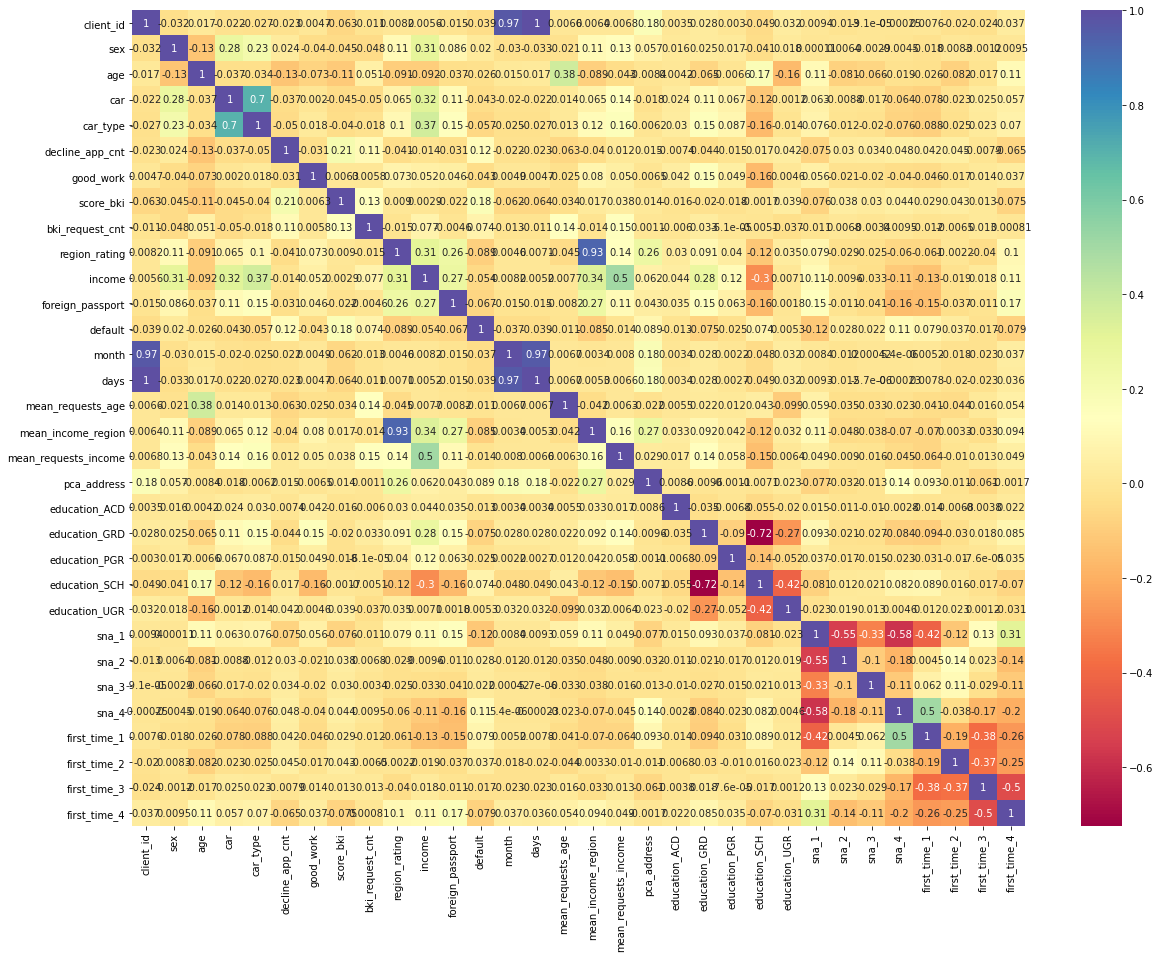

In [62]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_train.corr(), cmap='Spectral', annot=True)

<AxesSubplot:>

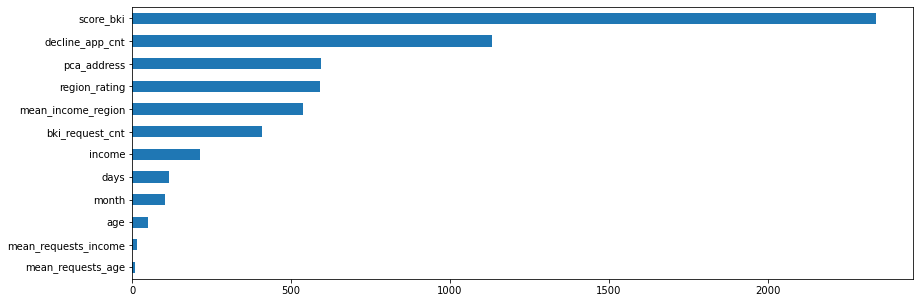

In [63]:
plt.figure(figsize=(14, 5))
imp_num = pd.Series(f_classif(df_train[num_cols],df_train['default'])[0],
                    index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

<AxesSubplot:>

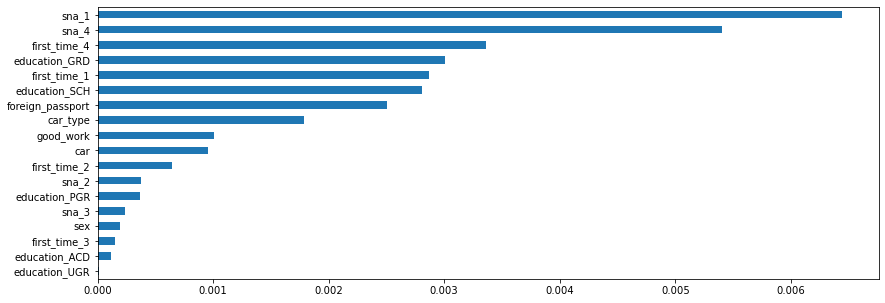

In [64]:
plt.figure(figsize=(14, 5))
imp_cat = pd.Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Есть очевидная корреляция между дамми переменными. Так же после преобразования бинарных признаков, стала видна сильная корреляция между признаками car и car_type. Ещё видна сильная корреляция между месяцами и днями, рейтингом региона и новым признаком mean_income_region. Объединим эти признаки методом pca. 

По графикам можно увидеть, что некоторые признаки не несут никакой пользы, возможно позже удалим их.

In [65]:
# Объединение car и car_type
features = ['car', 'car_type']
df['car_pca'] = create_pca(df, features)

df.drop(features, inplace=True, axis=1)

for i in features:
    bin_cols.remove(i)

num_cols.append('car_pca')

In [66]:
# Объединение days и month
features = ['days', 'month']
df['days_pca'] = create_pca(df, features)

df.drop(features, inplace=True, axis=1)

for i in features:
    num_cols.remove(i)

num_cols.append('days_pca')

In [67]:
# Объединение region_rating и mean_income_region
features = ['region_rating', 'mean_income_region']
df['region_mean_income_pca'] = create_pca(df, features)

df.drop(features, inplace=True, axis=1)

for i in features:
    num_cols.remove(i)

num_cols.append('region_mean_income_pca')

Посмотрим как изменилась матрица корреляций и графики значимости признаков после преобразований

In [68]:
df_train = df[df['sample'] == 1].drop(['sample'], axis=1)

<AxesSubplot:>

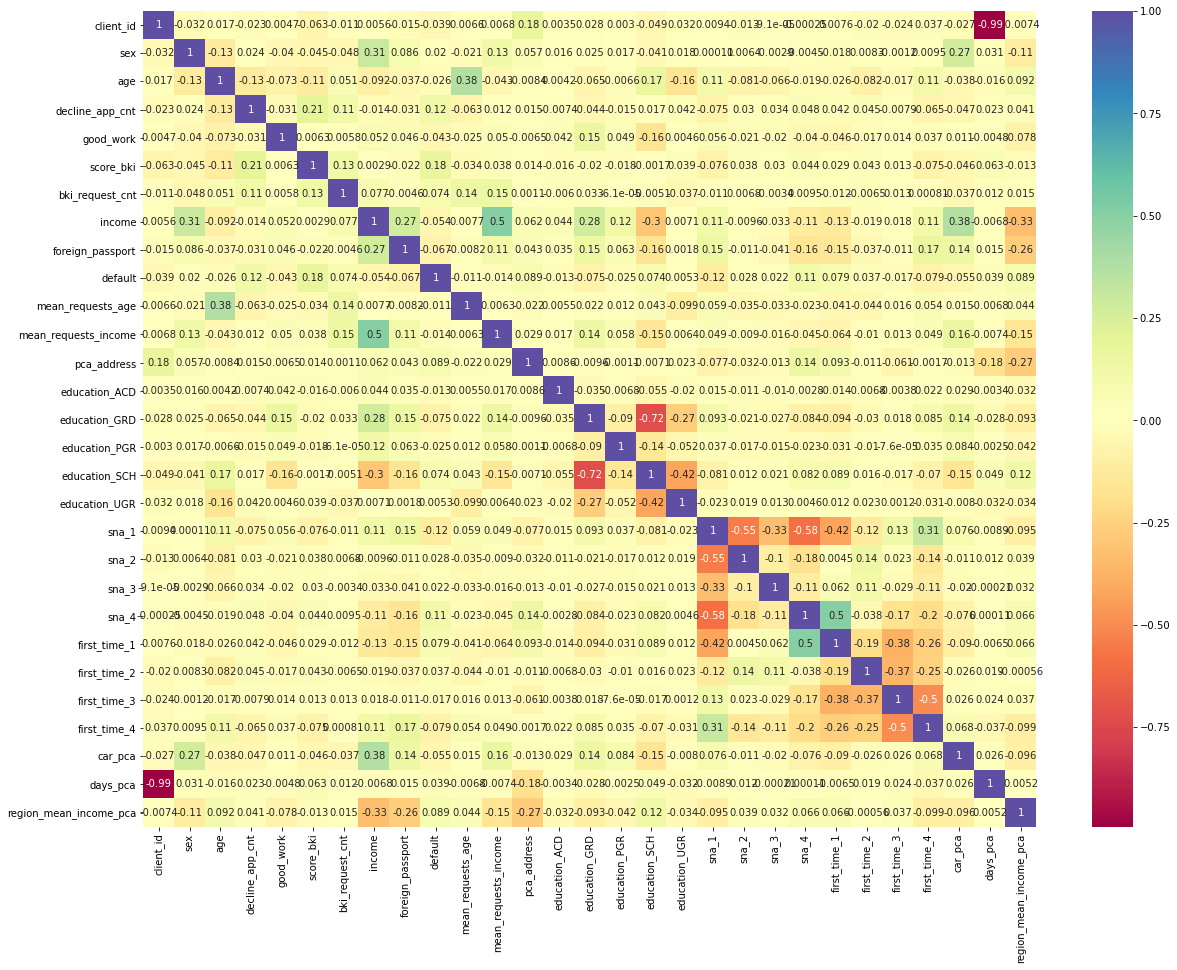

In [69]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_train.corr(), cmap='Spectral', annot=True)

<AxesSubplot:>

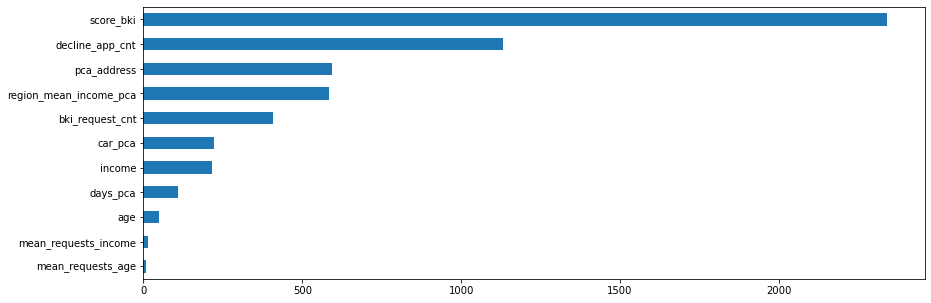

In [70]:
plt.figure(figsize=(14, 5))
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

<AxesSubplot:>

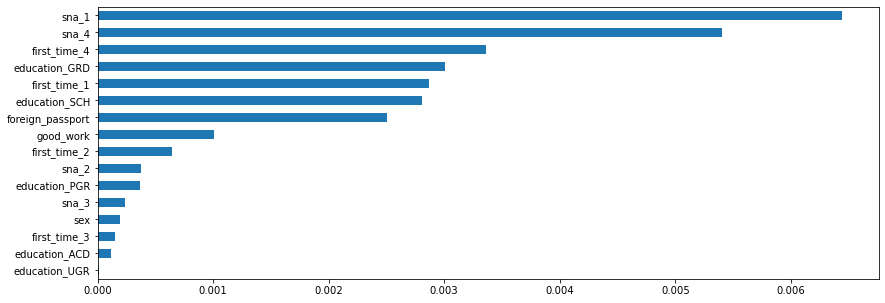

In [71]:
plt.figure(figsize=(14, 5))
imp_cat = pd.Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Мы избавились от всех сильных корреляций. Наши данные готовы к обучению, но сначала нужно провести предобработку данных

## Предобработка

In [72]:
# Разделим выборку на тест и трейн
train = df[df['sample'] == 1].drop(['sample'], axis=1)
test = df[df['sample'] == 0].drop(['sample'], axis=1)

Обозначим где X и где y, разделим X и y на тренировочный, валидационный и тестовый, а так же нормализуем X.

In [73]:
y = train['default']
X = train.drop(['default', 'client_id'], axis=1)

sc = RobustScaler()
X = sc.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED)

X_test = test.drop(['default', 'client_id'], axis=1)
X_test = sc.transform(X_test)

# Обучение моделей

Я остановила свой выбор на 3х моделях. Для начала посмотрим, как они будут работать без параметров и без применения методов для балансировки классов.

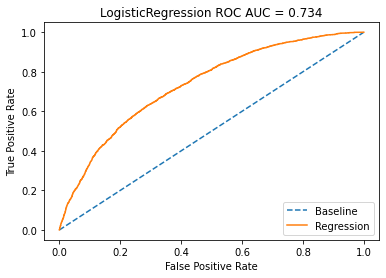

accuracy_score: 0.871869918699187
precision_score: 0.4661016949152542
recall_score: 0.0233446519524618
f1_score: 0.0444624090541633


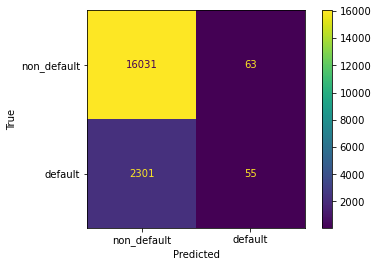

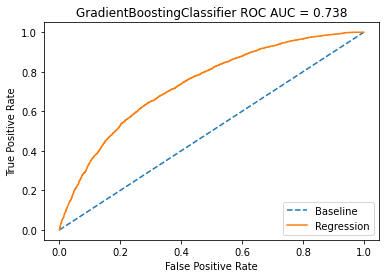

accuracy_score: 0.8723577235772357
precision_score: 0.5046728971962616
recall_score: 0.022920203735144314
f1_score: 0.0438489646772229


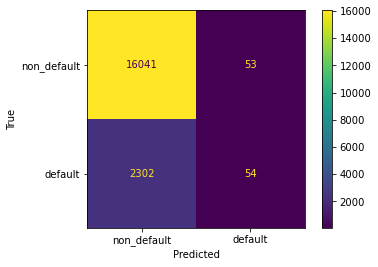

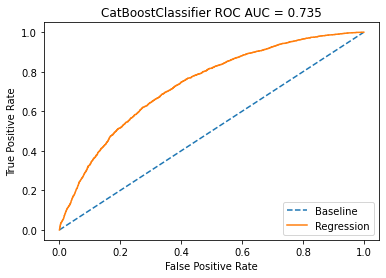

accuracy_score: 0.8715989159891598
precision_score: 0.4666666666666667
recall_score: 0.03862478777589134
f1_score: 0.07134457075656606


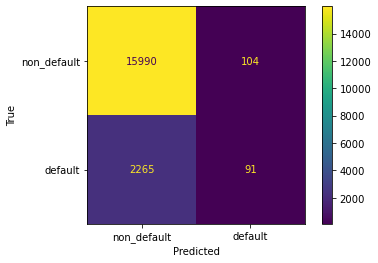

In [74]:
models = [LogisticRegression(), 
          GradientBoostingClassifier(),
          CatBoostClassifier(verbose=False)]

for model in models:
    report = report.append(classification_and_metrics(model, X_train, y_train, X_valid),
                           ignore_index=True)

In [75]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.476190,0.021222,0.040634,"[[16039, 55], [2306, 50]]"
1,LogisticRegression,0.734496,0.871870,0.466102,0.023345,0.044462,"[[16031, 63], [2301, 55]]"
2,GradientBoostingClassifier,0.738154,0.872358,0.504673,0.022920,0.043849,"[[16041, 53], [2302, 54]]"
3,CatBoostClassifier,0.735193,0.871599,0.466667,0.038625,0.071345,"[[15990, 104], [2265, 91]]"


Мы улучшили значения метрики roc-auc, но модели по прежнему выдают кредит практически всем. Нужно сбалансировать классы. Для начала попробуем метод OverSampler.

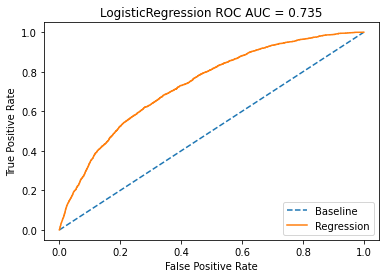

accuracy_score: 0.6656910569105691
precision_score: 0.22685583261679565
recall_score: 0.6719015280135824
f1_score: 0.33919005785301054


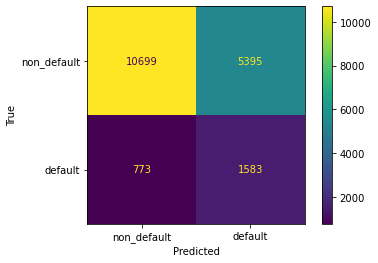

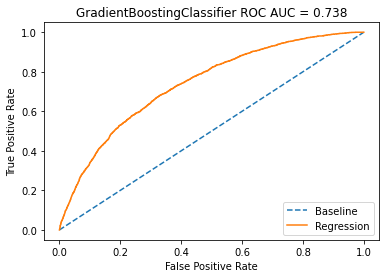

accuracy_score: 0.6693766937669376
precision_score: 0.23103448275862068
recall_score: 0.6825127334465195
f1_score: 0.3452125375697724


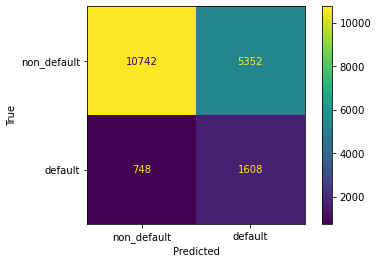

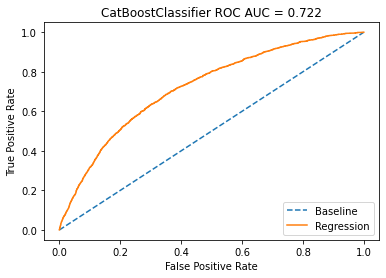

accuracy_score: 0.7242818428184282
precision_score: 0.24967919340054995
recall_score: 0.5780984719864176
f1_score: 0.348738957879913


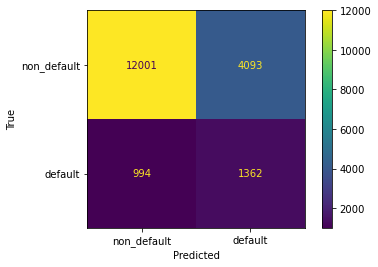

In [76]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)
for model in models:
    report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='OverSampler'),
                           ignore_index=True)

In [77]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.476190,0.021222,0.040634,"[[16039, 55], [2306, 50]]"
1,LogisticRegression,0.734496,0.871870,0.466102,0.023345,0.044462,"[[16031, 63], [2301, 55]]"
2,GradientBoostingClassifier,0.738154,0.872358,0.504673,0.022920,0.043849,"[[16041, 53], [2302, 54]]"
3,CatBoostClassifier,0.735193,0.871599,0.466667,0.038625,0.071345,"[[15990, 104], [2265, 91]]"
4,LogisticRegressionOverSampler,0.734743,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
5,GradientBoostingClassifierOverSampler,0.738188,0.669377,0.231034,0.682513,0.345213,"[[10742, 5352], [748, 1608]]"
6,CatBoostClassifierOverSampler,0.722365,0.724282,0.249679,0.578098,0.348739,"[[12001, 4093], [994, 1362]]"


Метрика roc-auc незначительно увеличилась у Логистической регрессии и Градиентного бустинга, а у Catboost упала больше чем на 0,01. Значение всех метрик кроме accuracy улучшилось, модель начала предсказывать дефолтных клиентов. Попробуем подобрать гиперпараметры для этих моделей используя библиотеку optuna

In [78]:
# подбор гиперпараметров для логистической регрессии
def objective(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg'])}

    logreg = LogisticRegression(**param)

    logreg.fit(X_train, y_train)

    preds = logreg.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:02:40,775] A new study created in memory with name: no-name-4479750e-88df-485f-a634-3be7254ea068
[I 2021-11-29 19:02:43,553] Trial 0 finished with value: 0.7347429406143828 and parameters: {'C': 1.1495466416544262, 'solver': 'sag'}. Best is trial 0 with value: 0.7347429406143828.
[I 2021-11-29 19:02:44,799] Trial 1 finished with value: 0.734744892221695 and parameters: {'C': 8.538939491632332, 'solver': 'saga'}. Best is trial 1 with value: 0.734744892221695.
[I 2021-11-29 19:02:45,984] Trial 2 finished with value: 0.7347439691641825 and parameters: {'C': 1.7069576927419856, 'solver': 'saga'}. Best is trial 1 with value: 0.734744892221695.
[I 2021-11-29 19:02:46,367] Trial 3 finished with value: 0.7347483470940988 and parameters: {'C': 7.737805085101093, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7347483470940988.
[I 2021-11-29 19:02:48,817] Trial 4 finished with value: 0.7347305188975719 and parameters: {'C': 0.14468983406458932, 'solver': 'saga'}. Best is trial

[I 2021-11-29 19:03:09,888] Trial 41 finished with value: 0.7347490327939654 and parameters: {'C': 7.4501165255469655, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.7347492701516114.
[I 2021-11-29 19:03:10,267] Trial 42 finished with value: 0.7347465800982892 and parameters: {'C': 7.64181473817283, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.7347492701516114.
[I 2021-11-29 19:03:10,651] Trial 43 finished with value: 0.7347463427406432 and parameters: {'C': 6.223938353554256, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.7347492701516114.
[I 2021-11-29 19:03:11,029] Trial 44 finished with value: 0.734747344917371 and parameters: {'C': 8.41362523321496, 'solver': 'lbfgs'}. Best is trial 11 with value: 0.7347492701516114.
[I 2021-11-29 19:03:11,977] Trial 45 finished with value: 0.7347443647602593 and parameters: {'C': 5.5196573130010975, 'solver': 'sag'}. Best is trial 11 with value: 0.7347492701516114.
[I 2021-11-29 19:03:12,323] Trial 46 finished with value: 0.73474829

[I 2021-11-29 19:03:31,600] Trial 82 finished with value: 0.7347473449173711 and parameters: {'C': 7.511291250727891, 'solver': 'lbfgs'}. Best is trial 77 with value: 0.7347493756438985.
[I 2021-11-29 19:03:32,030] Trial 83 finished with value: 0.7347464746060021 and parameters: {'C': 8.128164658097358, 'solver': 'lbfgs'}. Best is trial 77 with value: 0.7347493756438985.
[I 2021-11-29 19:03:32,404] Trial 84 finished with value: 0.7347465537252174 and parameters: {'C': 7.158716953360601, 'solver': 'lbfgs'}. Best is trial 77 with value: 0.7347493756438985.
[I 2021-11-29 19:03:32,800] Trial 85 finished with value: 0.7347463427406432 and parameters: {'C': 6.415811013554879, 'solver': 'lbfgs'}. Best is trial 77 with value: 0.7347493756438985.
[I 2021-11-29 19:03:33,166] Trial 86 finished with value: 0.7347474240365863 and parameters: {'C': 6.027195521236964, 'solver': 'lbfgs'}. Best is trial 77 with value: 0.7347493756438985.
[I 2021-11-29 19:03:33,516] Trial 87 finished with value: 0.73474

Number of finished trials: 100
Best trial:
  Value: 0.7347493756438985
  Params: 
    C: 7.992315521685244
    solver: lbfgs


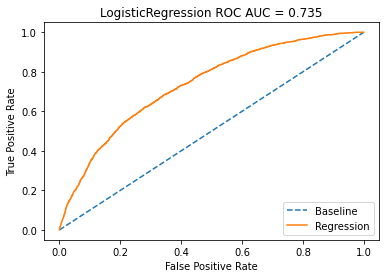

accuracy_score: 0.6656910569105691
precision_score: 0.22685583261679565
recall_score: 0.6719015280135824
f1_score: 0.33919005785301054


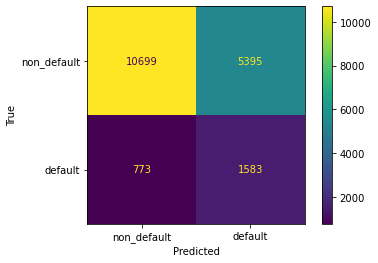

In [85]:
model = LogisticRegression(C=7.992315521685244, 
                           solver='lbfgs')
report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='Over_Hyper'),
                       ignore_index=True)

In [80]:
# Подбор гиперпараметров для GradientBoostingClassifier
def objective(trial):

    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 2.1),
        'max_depth': trial.suggest_int('max_depth', 1, 15)

    }

    gbc = GradientBoostingClassifier(**param)

    gbc.fit(X_train, y_train)

    preds = gbc.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:03:39,061] A new study created in memory with name: no-name-306a91e7-48b7-4a2b-994b-bf7ff2949935
[I 2021-11-29 19:04:03,278] Trial 0 finished with value: 0.6817627228445446 and parameters: {'loss': 'exponential', 'n_estimators': 113, 'learning_rate': 2.0238120212916346, 'max_depth': 4}. Best is trial 0 with value: 0.6817627228445446.
[I 2021-11-29 19:06:25,386] Trial 1 finished with value: 0.6741318986944907 and parameters: {'loss': 'deviance', 'n_estimators': 160, 'learning_rate': 0.5895572480077869, 'max_depth': 14}. Best is trial 0 with value: 0.6817627228445446.
[I 2021-11-29 19:06:45,633] Trial 2 finished with value: 0.6831243777273711 and parameters: {'loss': 'exponential', 'n_estimators': 29, 'learning_rate': 0.3116651427960345, 'max_depth': 12}. Best is trial 2 with value: 0.6831243777273711.
[I 2021-11-29 19:08:35,493] Trial 3 finished with value: 0.6701940034808236 and parameters: {'loss': 'deviance', 'n_estimators': 96, 'learning_rate': 0.5080012025279714, '

Number of finished trials: 18
Best trial:
  Value: 0.7336642819783517
  Params: 
    loss: deviance
    n_estimators: 68
    learning_rate: 1.4236037841089808
    max_depth: 1


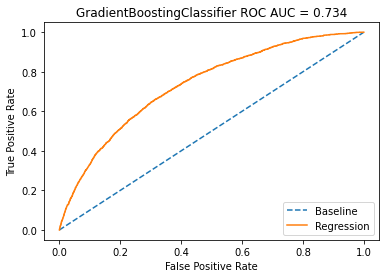

accuracy_score: 0.6672086720867209
precision_score: 0.22816091954022988
recall_score: 0.6740237691001698
f1_score: 0.3409188492915415


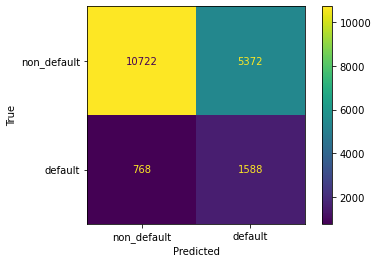

In [86]:
model = GradientBoostingClassifier(loss='deviance',
                                   n_estimators=68,
                                   learning_rate= 1.4236037841089808,
                                   max_depth=1
                                   )

report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='Over_Hyper'),
                       ignore_index=True)

In [82]:
# Подбор гиперпараметров для CatBoostClassifier
def objective(trial):

    param = {
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 12),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']
        ),
        'used_ram_limit': '3gb',
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    cbc = CatBoostClassifier(**param)

    cbc.fit(X_train, y_train, eval_set=[
            (X_valid, y_valid)], verbose=0, early_stopping_rounds=100)

    preds = cbc.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:14:09,670] A new study created in memory with name: no-name-46c3f845-deb0-4e63-a07c-6e65186c7847
[I 2021-11-29 19:14:16,186] Trial 0 finished with value: 0.7392777507483095 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02689200825112048, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7392777507483095.
[I 2021-11-29 19:14:26,251] Trial 1 finished with value: 0.7303103129470896 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06724666208544926, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8456927671372797}. Best is trial 0 with value: 0.7392777507483095.
[I 2021-11-29 19:14:33,469] Trial 2 finished with value: 0.7361362827429598 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.031091972652712935, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7392777507483095.
[I 2021-11-29 19:15:11,841] 

Number of finished trials: 26
Best trial:
  Value: 0.7414230287131016
  Params: 
    objective: Logloss
    colsample_bylevel: 0.06024946028852799
    depth: 3
    boosting_type: Plain
    bootstrap_type: MVS


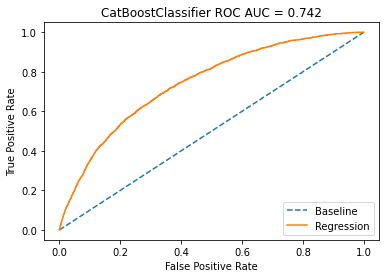

accuracy_score: 0.6702981029810298
precision_score: 0.2323711044090191
recall_score: 0.6867572156196944
f1_score: 0.34724755875093893


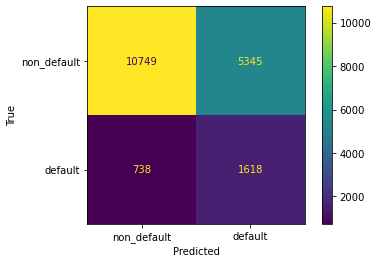

In [90]:
model=CatBoostClassifier(objective='Logloss',
                         colsample_bylevel=0.06024946028852799,
                         depth=3,
                         boosting_type = 'Plain',
                         bootstrap_type= 'MVS',
                         verbose=False
                        )

report = report.append(classification_and_metrics(model, X_train,y_train, X_valid,name = 'Over_Hyperparameters'),
                            ignore_index=True)

In [91]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.476190,0.021222,0.040634,"[[16039, 55], [2306, 50]]"
1,LogisticRegression,0.734496,0.871870,0.466102,0.023345,0.044462,"[[16031, 63], [2301, 55]]"
2,GradientBoostingClassifier,0.738154,0.872358,0.504673,0.022920,0.043849,"[[16041, 53], [2302, 54]]"
3,CatBoostClassifier,0.735193,0.871599,0.466667,0.038625,0.071345,"[[15990, 104], [2265, 91]]"
4,LogisticRegressionOverSampler,0.734743,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
5,GradientBoostingClassifierOverSampler,0.738188,0.669377,0.231034,0.682513,0.345213,"[[10742, 5352], [748, 1608]]"
6,CatBoostClassifierOverSampler,0.722365,0.724282,0.249679,0.578098,0.348739,"[[12001, 4093], [994, 1362]]"
7,LogisticRegressionOver_Hyper,0.734749,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
8,GradientBoostingClassifierOver_Hyper,0.733664,0.667209,0.228161,0.674024,0.340919,"[[10722, 5372], [768, 1588]]"
9,CatBoostClassifierOver_Hyperparameters,0.741636,0.670298,0.232371,0.686757,0.347248,"[[10749, 5345], [738, 1618]]"


После подбора гиперпараметров самые значимые изменения были у модели Catboost, она стала лучше предсказывать дефолтных клиентов, и в целом улучшились показатели практически по всем метрикам.

Теперь попробуем сбалансировать классы методом UnderSampler.

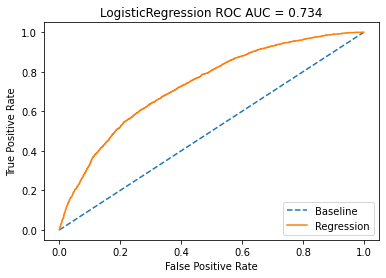

accuracy_score: 0.6682926829268293
precision_score: 0.2272463768115942
recall_score: 0.66553480475382
f1_score: 0.3388072601555748


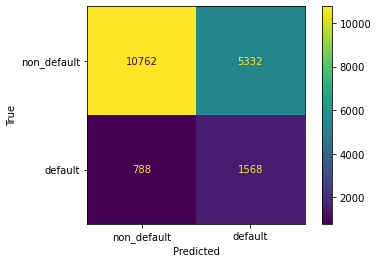

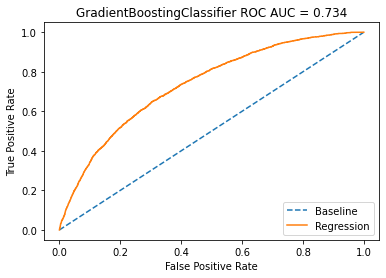

accuracy_score: 0.6665040650406504
precision_score: 0.22812544751539454
recall_score: 0.6761460101867572
f1_score: 0.3411500160616769


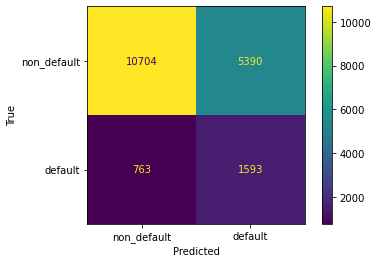

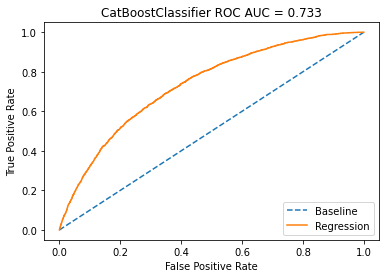

accuracy_score: 0.656639566395664
precision_score: 0.2247890441278185
recall_score: 0.6897283531409168
f1_score: 0.33907146583202924


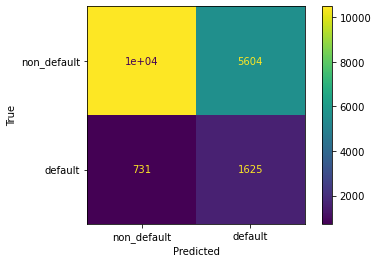

In [92]:
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED)
X_train, y_train = rus.fit_resample(X_train, y_train)
for model in models:
    report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='UnderSampler'),
                           ignore_index=True)

In [93]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.476190,0.021222,0.040634,"[[16039, 55], [2306, 50]]"
1,LogisticRegression,0.734496,0.871870,0.466102,0.023345,0.044462,"[[16031, 63], [2301, 55]]"
2,GradientBoostingClassifier,0.738154,0.872358,0.504673,0.022920,0.043849,"[[16041, 53], [2302, 54]]"
3,CatBoostClassifier,0.735193,0.871599,0.466667,0.038625,0.071345,"[[15990, 104], [2265, 91]]"
4,LogisticRegressionOverSampler,0.734743,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
5,GradientBoostingClassifierOverSampler,0.738188,0.669377,0.231034,0.682513,0.345213,"[[10742, 5352], [748, 1608]]"
6,CatBoostClassifierOverSampler,0.722365,0.724282,0.249679,0.578098,0.348739,"[[12001, 4093], [994, 1362]]"
7,LogisticRegressionOver_Hyper,0.734749,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
8,GradientBoostingClassifierOver_Hyper,0.733664,0.667209,0.228161,0.674024,0.340919,"[[10722, 5372], [768, 1588]]"
9,CatBoostClassifierOver_Hyperparameters,0.741636,0.670298,0.232371,0.686757,0.347248,"[[10749, 5345], [738, 1618]]"


Модели по всем метрикам немного уступают методу OverSampler, но возможно гиперпараметры изменят эту ситуацию. 

In [94]:
# подбор гиперпараметров для логистической регрессии
def objective(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg'])}

    logreg = LogisticRegression(**param)

    logreg.fit(X_train, y_train)

    preds = logreg.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:34:06,326] A new study created in memory with name: no-name-f6cbfb95-1c6d-4bc3-897c-de96b3a89f68
[I 2021-11-29 19:34:06,680] Trial 0 finished with value: 0.7335407505101079 and parameters: {'C': 6.35110494259703, 'solver': 'sag'}. Best is trial 0 with value: 0.7335407505101079.
[I 2021-11-29 19:34:06,740] Trial 1 finished with value: 0.7335409351216104 and parameters: {'C': 9.962627946859563, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7335409351216104.
[I 2021-11-29 19:34:07,241] Trial 2 finished with value: 0.733539510975734 and parameters: {'C': 6.100568683375612, 'solver': 'saga'}. Best is trial 1 with value: 0.7335409351216104.
[I 2021-11-29 19:34:07,385] Trial 3 finished with value: 0.7335410142408257 and parameters: {'C': 7.176778373809701, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.7335410142408257.
[I 2021-11-29 19:34:07,447] Trial 4 finished with value: 0.7335353176573202 and parameters: {'C': 1.5122011180708674, 'solver': 'liblinear'}. B

[I 2021-11-29 19:34:14,067] Trial 40 finished with value: 0.7335406977639644 and parameters: {'C': 6.706441889366524, 'solver': 'sag'}. Best is trial 32 with value: 0.7335416208214768.
[I 2021-11-29 19:34:14,189] Trial 41 finished with value: 0.7335414098369026 and parameters: {'C': 8.358251869454323, 'solver': 'newton-cg'}. Best is trial 32 with value: 0.7335416208214768.
[I 2021-11-29 19:34:14,327] Trial 42 finished with value: 0.7335415680753333 and parameters: {'C': 9.150026025148808, 'solver': 'newton-cg'}. Best is trial 32 with value: 0.7335416208214768.
[I 2021-11-29 19:34:14,434] Trial 43 finished with value: 0.7335415417022615 and parameters: {'C': 9.31023303520707, 'solver': 'newton-cg'}. Best is trial 32 with value: 0.7335416208214768.
[I 2021-11-29 19:34:14,546] Trial 44 finished with value: 0.7335413834638307 and parameters: {'C': 9.585882940104085, 'solver': 'newton-cg'}. Best is trial 32 with value: 0.7335416208214768.
[I 2021-11-29 19:34:14,675] Trial 45 finished with v

[I 2021-11-29 19:34:21,510] Trial 81 finished with value: 0.7335416999406922 and parameters: {'C': 8.078306348562984, 'solver': 'newton-cg'}. Best is trial 81 with value: 0.7335416999406922.
[I 2021-11-29 19:34:21,648] Trial 82 finished with value: 0.7335415417022615 and parameters: {'C': 8.194155143212885, 'solver': 'newton-cg'}. Best is trial 81 with value: 0.7335416999406922.
[I 2021-11-29 19:34:21,800] Trial 83 finished with value: 0.7335414625830462 and parameters: {'C': 7.956596681834784, 'solver': 'newton-cg'}. Best is trial 81 with value: 0.7335416999406922.
[I 2021-11-29 19:34:21,952] Trial 84 finished with value: 0.7335412779715436 and parameters: {'C': 7.436052286337893, 'solver': 'newton-cg'}. Best is trial 81 with value: 0.7335416999406922.
[I 2021-11-29 19:34:22,116] Trial 85 finished with value: 0.7335414362099745 and parameters: {'C': 8.674081970835365, 'solver': 'newton-cg'}. Best is trial 81 with value: 0.7335416999406922.
[I 2021-11-29 19:34:22,242] Trial 86 finished

Number of finished trials: 100
Best trial:
  Value: 0.7335416999406922
  Params: 
    C: 8.078306348562984
    solver: newton-cg


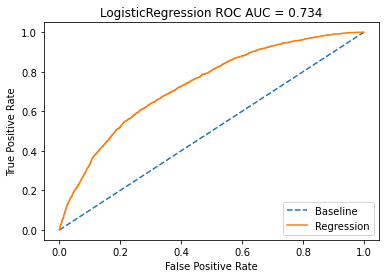

accuracy_score: 0.6682384823848239
precision_score: 0.22721344732647442
recall_score: 0.66553480475382
f1_score: 0.33877066004105


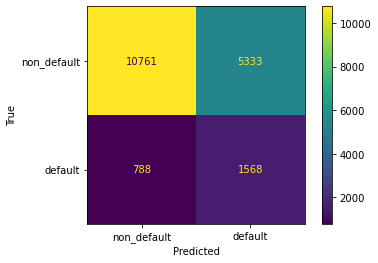

In [97]:
model = LogisticRegression(C=8.078306348562984, 
                           solver='newton-cg')
report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='Under_Hyper'),
                       ignore_index=True)

In [95]:
# Подбор гиперпараметров для GradientBoostingClassifier
def objective(trial):

    param = {
        'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 2.1),
        'max_depth': trial.suggest_int('max_depth', 1, 15)

    }

    gbc = GradientBoostingClassifier(**param)

    gbc.fit(X_train, y_train)

    preds = gbc.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:34:25,139] A new study created in memory with name: no-name-351e6142-ea30-4c0e-ae61-c4312bcd1a34
[I 2021-11-29 19:34:36,131] Trial 0 finished with value: 0.6619703786097086 and parameters: {'loss': 'deviance', 'n_estimators': 196, 'learning_rate': 1.0779144346178522, 'max_depth': 8}. Best is trial 0 with value: 0.6619703786097086.
[I 2021-11-29 19:34:42,686] Trial 1 finished with value: 0.6512917504187515 and parameters: {'loss': 'deviance', 'n_estimators': 107, 'learning_rate': 1.0991472038309176, 'max_depth': 9}. Best is trial 0 with value: 0.6619703786097086.
[I 2021-11-29 19:34:49,340] Trial 2 finished with value: 0.6688229334113696 and parameters: {'loss': 'exponential', 'n_estimators': 90, 'learning_rate': 1.230572893965109, 'max_depth': 10}. Best is trial 2 with value: 0.6688229334113696.
[I 2021-11-29 19:34:52,151] Trial 3 finished with value: 0.6356210425887132 and parameters: {'loss': 'exponential', 'n_estimators': 63, 'learning_rate': 1.776209922650113, 'max

[I 2021-11-29 19:36:47,546] Trial 33 finished with value: 0.7311665410956809 and parameters: {'loss': 'deviance', 'n_estimators': 178, 'learning_rate': 0.15544889742711754, 'max_depth': 3}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:36:50,110] Trial 34 finished with value: 0.7362265313946101 and parameters: {'loss': 'deviance', 'n_estimators': 197, 'learning_rate': 0.1425582870818516, 'max_depth': 2}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:36:56,111] Trial 35 finished with value: 0.7195647630864764 and parameters: {'loss': 'exponential', 'n_estimators': 196, 'learning_rate': 0.13823602042849473, 'max_depth': 5}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:36:58,210] Trial 36 finished with value: 0.7362894971034983 and parameters: {'loss': 'deviance', 'n_estimators': 157, 'learning_rate': 0.15671578645431225, 'max_depth': 2}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:37:02,163] Trial 37 finis

[I 2021-11-29 19:39:10,221] Trial 66 finished with value: 0.7354813075051643 and parameters: {'loss': 'deviance', 'n_estimators': 167, 'learning_rate': 0.20242508572089288, 'max_depth': 2}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:39:11,176] Trial 67 finished with value: 0.7038140393566406 and parameters: {'loss': 'deviance', 'n_estimators': 129, 'learning_rate': 0.01943751535100574, 'max_depth': 1}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:39:13,993] Trial 68 finished with value: 0.7249418104544123 and parameters: {'loss': 'deviance', 'n_estimators': 150, 'learning_rate': 0.2955928317756278, 'max_depth': 3}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:39:15,316] Trial 69 finished with value: 0.7326672875591046 and parameters: {'loss': 'deviance', 'n_estimators': 181, 'learning_rate': 0.1509040935180914, 'max_depth': 1}. Best is trial 30 with value: 0.7363827127257245.
[I 2021-11-29 19:39:19,983] Trial 70 finished 

[I 2021-11-29 19:40:27,089] Trial 99 finished with value: 0.6844858216256235 and parameters: {'loss': 'deviance', 'n_estimators': 48, 'learning_rate': 0.010202646359334655, 'max_depth': 2}. Best is trial 30 with value: 0.7363827127257245.


Number of finished trials: 100
Best trial:
  Value: 0.7363827127257245
  Params: 
    loss: deviance
    n_estimators: 177
    learning_rate: 0.17372536075796763
    max_depth: 2


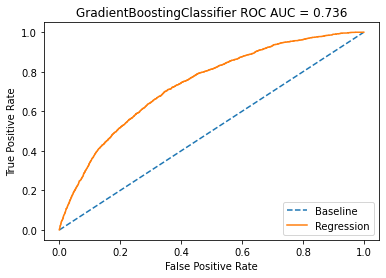

accuracy_score: 0.6656368563685637
precision_score: 0.22915186816309135
recall_score: 0.684634974533107
f1_score: 0.3433741351782863


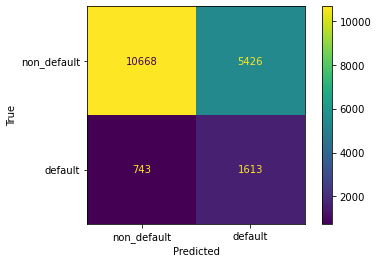

In [98]:
model = GradientBoostingClassifier(loss='deviance', 
                                   n_estimators=177,
                                   learning_rate= 0.17372536075796763,
                                   max_depth=2
                                   )

report = report.append(classification_and_metrics(model, X_train, y_train, X_valid, name='Under_Hyper'),
                       ignore_index=True)

In [96]:
# Подбор гиперпараметров для CatBoostClassifier
def objective(trial):

    param = {
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 12),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']
        ),
        'used_ram_limit': '3gb',
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    cbc = CatBoostClassifier(**param)

    cbc.fit(X_train, y_train, eval_set=[
            (X_valid, y_valid)], verbose=0, early_stopping_rounds=100)

    preds = cbc.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    return roc_auc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print(f'Number of finished trials: {len(study.trials)}')

    print('Best trial:')
    trial = study.best_trial

    print(f'  Value: {trial.value}')

    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2021-11-29 19:40:27,122] A new study created in memory with name: no-name-7c5a25a1-a8c8-4665-9a27-8b63b263bc07
[I 2021-11-29 19:40:29,665] Trial 0 finished with value: 0.7333687189628505 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.021450200845336914, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2602546817809355}. Best is trial 0 with value: 0.7333687189628505.
[I 2021-11-29 19:40:37,186] Trial 1 finished with value: 0.7372034954658361 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06478898970259186, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.921894648324171}. Best is trial 1 with value: 0.7372034954658361.
[I 2021-11-29 19:40:47,068] Trial 2 finished with value: 0.7372433188042322 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07610566564382218, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample

[I 2021-11-29 19:42:22,898] Trial 25 finished with value: 0.7369552984872618 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08930719675783352, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12230980976760425}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:42:25,610] Trial 26 finished with value: 0.735759226935641 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07916793442597989, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2406049054445147}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:42:32,881] Trial 27 finished with value: 0.7286719122354808 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07036092132149793, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.1710986015418845}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:42:36,772] Trial 

[I 2021-11-29 19:44:17,679] Trial 51 finished with value: 0.7387174416516885 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08627683535319891, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:44:21,531] Trial 52 finished with value: 0.7376571386736201 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07842872163935852, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:44:25,336] Trial 53 finished with value: 0.7383049931820335 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08754199883644885, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 20 with value: 0.7390848185416619.
[I 2021-11-29 19:44:29,234] Trial 54 finished with value: 0.7383806047788428 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09988885925001179, '

[I 2021-11-29 19:46:11,216] Trial 79 finished with value: 0.7379243506369519 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.053345399891177085, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 61 with value: 0.7392132817743295.
[I 2021-11-29 19:46:15,165] Trial 80 finished with value: 0.7386679921420906 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06421392677935363, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19631514961792096}. Best is trial 61 with value: 0.7392132817743295.
[I 2021-11-29 19:46:18,943] Trial 81 finished with value: 0.7384878904348665 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09767826617807567, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 61 with value: 0.7392132817743295.
[I 2021-11-29 19:46:23,347] Trial 82 finished with value: 0.7388269426457424 and parameters: {'objective': 'CrossEnt

Number of finished trials: 100
Best trial:
  Value: 0.7392132817743295
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.08586899620175843
    depth: 5
    boosting_type: Plain
    bootstrap_type: MVS


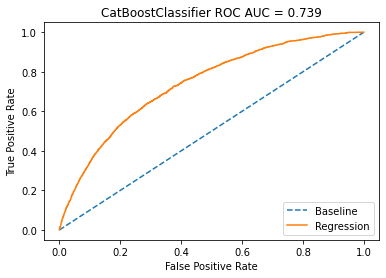

accuracy_score: 0.6586449864498645
precision_score: 0.22625
recall_score: 0.6914261460101867
f1_score: 0.3409376308078694


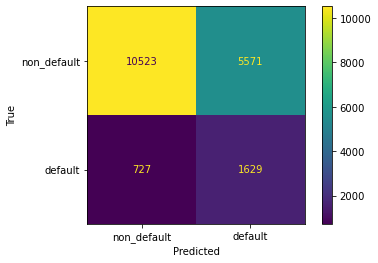

In [99]:
model=CatBoostClassifier(objective='CrossEntropy',
                         colsample_bylevel=0.08586899620175843,
                         depth=5,
                         boosting_type = 'Plain',
                         bootstrap_type= 'MVS',                         
                         verbose=False
                        )

report = report.append(classification_and_metrics(model, X_train,y_train, X_valid,name = 'Under_Hyper'),
                            ignore_index=True)

In [100]:
display(report)

,model,roc_auc,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegressionBase,0.721904,0.872033,0.476190,0.021222,0.040634,"[[16039, 55], [2306, 50]]"
1,LogisticRegression,0.734496,0.871870,0.466102,0.023345,0.044462,"[[16031, 63], [2301, 55]]"
2,GradientBoostingClassifier,0.738154,0.872358,0.504673,0.022920,0.043849,"[[16041, 53], [2302, 54]]"
3,CatBoostClassifier,0.735193,0.871599,0.466667,0.038625,0.071345,"[[15990, 104], [2265, 91]]"
4,LogisticRegressionOverSampler,0.734743,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
5,GradientBoostingClassifierOverSampler,0.738188,0.669377,0.231034,0.682513,0.345213,"[[10742, 5352], [748, 1608]]"
6,CatBoostClassifierOverSampler,0.722365,0.724282,0.249679,0.578098,0.348739,"[[12001, 4093], [994, 1362]]"
7,LogisticRegressionOver_Hyper,0.734749,0.665691,0.226856,0.671902,0.339190,"[[10699, 5395], [773, 1583]]"
8,GradientBoostingClassifierOver_Hyper,0.733664,0.667209,0.228161,0.674024,0.340919,"[[10722, 5372], [768, 1588]]"
9,CatBoostClassifierOver_Hyperparameters,0.741636,0.670298,0.232371,0.686757,0.347248,"[[10749, 5345], [738, 1618]]"


После подбора гиперпараметров результаты метрик с UnderSampler улучшились, но с OverSampler все же выглядят лучше. Для Submission будем использовать модель Catboost сбалансировав классы методом OverSampler

# Submission

Optuna занималась подбором гиперпараметров несколько раз. Эти гиперпараметры показали лучший результат на Kaggle:

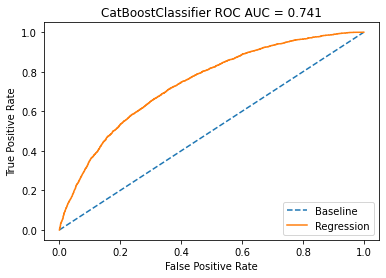

accuracy_score: 0.6710569105691057
precision_score: 0.23160329622668788
recall_score: 0.6799660441426146
f1_score: 0.3455192494338402


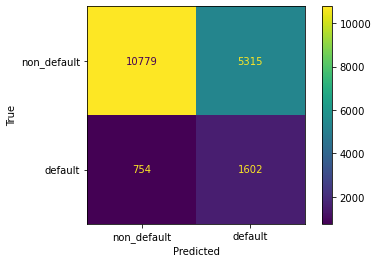

In [101]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

model=CatBoostClassifier(objective='CrossEntropy',
                         colsample_bylevel=0.07498402670931364,
                         depth=5,
                         boosting_type = 'Plain',
                         bootstrap_type= 'Bernoulli',
                         subsample = 0.30423749913256,
                         verbose=False
                        )


y_pred, probs, model_name = classification(model, X_train, y_train, X_valid)
print_metrics(y_valid, y_pred, probs, model_name)

In [102]:
# Предсказание результатов
probs = model.predict_proba(X_test)
probs = probs[:, 1]


my_submission = test[['client_id']]
my_submission['default'] = probs
my_submission.head(10)

,client_id,default
73799,74835,0.171934
73800,17527,0.721757
73801,75683,0.317517
73802,26883,0.387582
73803,28862,0.127753
73804,99881,0.504911
73805,26630,0.750958
73806,79934,0.281180
73807,16605,0.105810
73808,105449,0.113527


In [103]:
# Запись в файл
my_submission.to_csv('my_submission.csv', index=False)